## Import

In [ ]:
# install required python packages 

!pip install torch torchvision torchtext
!pip install pytorch-lightning
!pip install segmentation-models-pytorch
!pip install torchmetrics
!pip install torchmetrics --upgrade
!pip install pytorch-lightning --upgrade
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metad

In [ ]:
# import drive module from google.colab
# mount google drive file to colab notebook

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import required python packages

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score

from datetime import datetime
from typing import Any, Callable, Dict, List, Optional, Union, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision.models as models
from torchvision import transforms
from torchvision.datasets import Cityscapes
from torchvision.transforms import Compose

from torchsummary import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image

import segmentation_models_pytorch as smp

import pytorch_lightning as pl
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor

import multiprocessing

## Set Path

In [ ]:
# set up device for computation
device = torch.device('cuda:0')

# set a new folder path and new directory
DATA_DIR = '/content/drive/MyDrive/TDP_swin/test'
full_path = "/content/drive/MyDrive/TDP_swin/Sarah/model_20052023/model_checkpoint.pth"

## Set Functions

In [ ]:
# encode_segmap: remove unwanted classes 
# rectify the labels of desired classes by mapping them to 
# new classes in the class map dictionary

def encode_segmap(mask):
    for _voidc in void_classes:
        mask[mask == _voidc] = ignore_index
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

# take greyscale segmentation mask and convert to color-coded RGB image

def decode_segmap(temp):
    # convert gray scale to color
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]
    # normalisation by div by 255.0
    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [ ]:
# modify behaviour of retrieving items by applying transformations to images
# before returning them 
class MyClass(Cityscapes):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image = Image.open(self.images[index]).convert('RGB')

        targets: Any = []
        for i, t in enumerate(self.target_type):
            if t == 'polygon':
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])
            targets.append(target)
        target = tuple(targets) if len(targets) > 1 else targets[0]

        if self.transforms is not None:
            transformed=transform(image=np.array(image), mask=np.array(target))            
        return transformed['image'],transformed['mask']

## Functions for Metrics Calculation

In [ ]:
# calculate jaccard score for given segmentation output

def get_jaccard(output, avg_val):
  y_true = encode_segmap(seg)
  _,y_pred = torch.max(output, dim=1) 
  y_true = y_true.view(-1)
  y_pred = y_pred.view(-1)
  jaccard = jaccard_score(y_true.cpu().numpy(), y_pred.cpu().numpy(), average=avg_val)
  print(avg_val," jaccard: ", jaccard*100,"%")

# calculate Accuracy score and Jaccard Score/IoU
def get_metrics(gt_label, pred_label):
    # Accuracy Score
    acc = skm.accuracy_score(gt_label, pred_label, normalize=True)
    
    # Jaccard Score/IoU
    js = skm.jaccard_score(gt_label, pred_label, average='micro')
    
    result_gm_sh = [acc, js]
    return(result_gm_sh)

## Select Classes

In [ ]:
# check size of first image in dataset
dataset = Cityscapes(DATA_DIR, split='train', mode='fine', target_type='semantic')
dataset[0][0].size

(2048, 1024)

In [ ]:
# indicate pixels in the segmentation masks that are to be ignored
ignore_index=255

# define variables related to class labels
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21,27, 29, 30,31, 32, -1]
valid_classes = [ignore_index,7, 8, 11, 20, 22, 23, 24, 25, 26,  28,  33]
class_names = [
             "unlabelled",
             "road",
             "sidewalk",
             "building",
             "traffic_sign",
             "terrain",
             "sky",
             "person",
             "rider",
             "car",
             "bus",
             "bicycle",
         ]

# create map b/w class indices and their corresponding class colors
# this will set distinguishable colors for each class

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes=len(valid_classes)
class_colors = [[0, 0, 0], 
                   [128, 64, 128], 
                   [244, 35,232], 
                   [70, 70, 70], 
                   [220, 220, 0],
                   [152, 251, 152],  
                   [70, 130, 180], 
                   [220, 20, 60], 
                   [255, 0, 0],
                   [0, 0, 142], 
                   [0, 60, 100], 
                   [119, 11, 32]]
label_colours = dict(zip(range(n_classes), class_colors))

## Visualize Images

In [ ]:
# define a data augmentation pipeline using 'albumentations' library

transform=A.Compose(
[
    A.Resize(256, 512),
    A.HorizontalFlip(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
]
)
# these operations help with augmenting and preparing data for training a semantic segmentation model.

In [ ]:
# create instance of myclass with provided parameters
dataset=MyClass(DATA_DIR, split='val', mode='fine',
                     target_type='semantic',transforms=transform)

# retrieve 20th image from val set and it's segmentation mask
img,seg= dataset[20]
print(img.shape,seg.shape)

torch.Size([3, 256, 512]) torch.Size([256, 512])


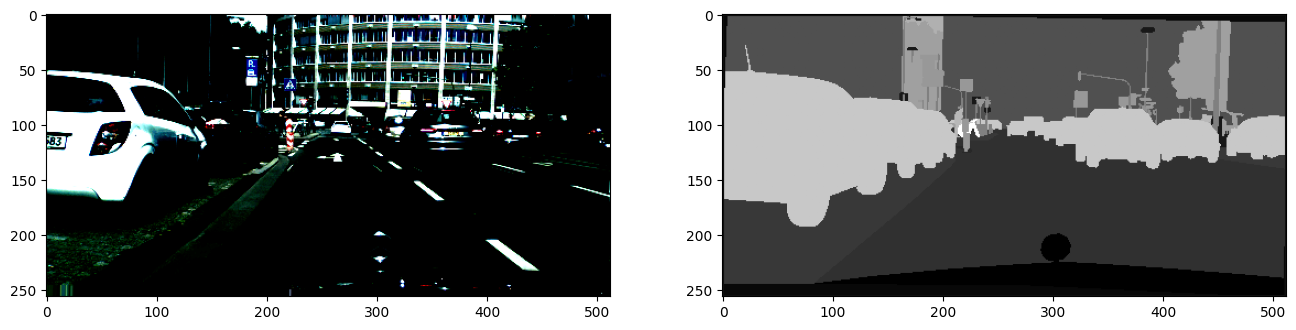

In [ ]:
# create two subplots displaying image and segmentation mask

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(seg,cmap='gray')

In [ ]:
# class labels before label correction
print(torch.unique(seg))
print(len(torch.unique(seg)))

tensor([ 1,  2,  3,  4,  6,  7,  8, 11, 17, 19, 20, 21, 23, 24, 26, 33],
       dtype=torch.uint8)
16


In [ ]:
# class labels after label correction
res=encode_segmap(seg.clone())
# print shape of corrected mask
print(res.shape)
print(torch.unique(res))
print(len(torch.unique(res)))

torch.Size([256, 512])
tensor([ 0,  1,  2,  3,  4,  6,  7,  9, 11], dtype=torch.uint8)
9


In [ ]:
# apply coloring to the corrected segmentation mask using decode_segmap()
res1=decode_segmap(res.clone())

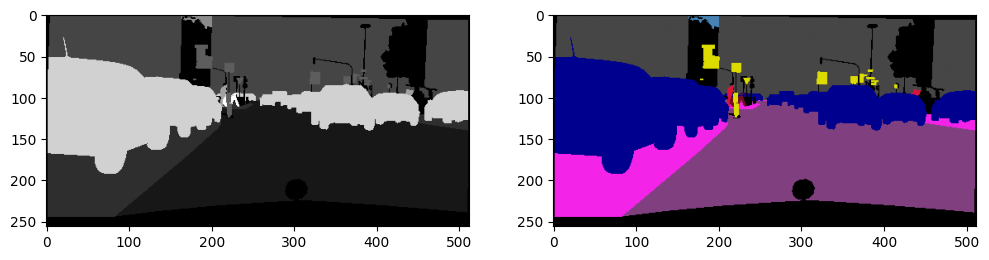

In [ ]:
# display corrected segmentation map and colored RGB image
fig,ax=plt.subplots(ncols=2,figsize=(12,10))  
ax[0].imshow(res,cmap='gray')
ax[1].imshow(res1)

## Model Architecture

In [ ]:
# define PyTorch Lightning module called OurModel for training and 
# evaluating semantic segmentation model.
class OurModel(LightningModule):
    def __init__(self):
        super(OurModel, self).__init__()
        # architecture
        self.layer = smp.Unet( 
            encoder_name="resnet34", 
            encoder_weights="imagenet", 
            in_channels=3,
            classes=n_classes,
        )

        # parameters
        self.lr = 1e-3 
        self.batch_size = 1 
        self.numworker = 4 

        self.criterion = torch.nn.CrossEntropyLoss() 

        self.train_class = MyClass(DATA_DIR, split='train', mode='fine',
                                   target_type='semantic', transforms=transform)
        self.val_class = MyClass(DATA_DIR, split='val', mode='fine',
                                 target_type='semantic', transforms=transform)
    
    # calculate jaccard index bw predicted segmentation and target segmentation
    def jaccard_index(self, pred, target):
        pred = torch.argmax(pred, dim=1)
        intersection = (pred * target).sum().float()
        union = (pred + target).sum().float() - intersection
        iou = (intersection + 1e-6) / (union + 1e-6)
        return iou
    
    # take image and corresponding segmentation, perform forward pass through
    # model, calculate loss and IoU, return them
    def process(self, image, segment):
        out = self(image)
        segment = encode_segmap(segment)
        loss = self.criterion(out, segment.long())
        iou = self.jaccard_index(out, segment)
        return loss, iou
    
    # defines forward pass of model by passing input image through
    # defined architecture
    def forward(self, x):
        return self.layer(x)
    
    # configures the optimizer for training
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return opt
    
    # return DataLoader for training dataset
    def train_dataloader(self):
        return DataLoader(self.train_class, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.numworker, pin_memory=True)
    
    # define training step, where input batch is processed, and the loss
    # and IoU are logged for monitoring during training.
    def training_step(self, batch, batch_idx):
        image, segment = batch
        loss, iou = self.process(image, segment)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_iou', iou, on_step=False, on_epoch=True, prog_bar=False)
        return loss

    # return DataLoader for validation dataset
    def val_dataloader(self):
        return DataLoader(self.val_class, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.numworker, pin_memory=True)
    
    # defines validation step, similar to training step where input bach is processed
    # and the loss and IoU are logged for monitoring during val
    def validation_step(self, batch, batch_idx):
        image, segment = batch
        loss, iou = self.process(image, segment)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log('val_iou', iou, on_step=False, on_epoch=True, prog_bar=False)
        return loss

## Model Training

In [ ]:
# create checkpoint callback for saving best model checkpoints during training
model = OurModel()
checkpoint_callback = ModelCheckpoint(monitor='val_iou',dirpath=full_path,
                                       filename='file',save_last=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 88.3MB/s]


In [ ]:
# create instance of PyTorch's trainer class and configure for training
trainer = pl.Trainer(max_epochs=120,
                     accelerator="gpu",
                     devices=-1,
                     precision="32",
                     callbacks=[checkpoint_callback])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# start training process using fit method of trainer object
# this trains model using specified config
trainer.fit(model)
# save the model after trained
torch.save(model.state_dict(), "/content/drive/MyDrive/TDP_swin/Sarah/model_20052023/model_checkpoint.pth")

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/drive/.shortcut-targets-by-id/1k0_QWlIezxIaVP2iBpxtHFpWEDVT-36R/TDP_swin/Sarah/model_20052023 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | layer     | Unet             | 24.4 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.752    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=120` reached.


## Evaluation
### Load Saved Model

In [ ]:
# check availability of CUDA-enabled GPU and assign appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# load the saved model
model = OurModel()
model.load_state_dict(torch.load("/content/drive/MyDrive/TDP_swin/Sarah/model_20052023/model_checkpoint.pth"))

model = model.to(device)
model.eval()

OurModel(
  (layer): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchN

In [ ]:
# retrieve final training loss and training jaccard 
train_loss = trainer.logged_metrics['train_loss']
train_iou = trainer.logged_metrics['train_iou']

print("Final Training Loss:", train_loss)
print("Final Training IoU:", train_iou)

Final Training Loss: tensor(0.1450)
Final Training IoU: tensor(68460656.)


In [ ]:
# retrieve final validation loss and validation IoU
val_loss = trainer.logged_metrics['val_loss']
val_iou = trainer.logged_metrics['val_iou']

print("Final Validation Loss:", val_loss)
print("Final Validation IoU:", val_iou) 

Final Validation Loss: tensor(0.5703)
Final Validation IoU: tensor(0.9359)


In [ ]:
# perform a single validation pass over the validation dataset using specified model
trainer.validate(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │    1.2986799478530884     │
│         val_loss          │    0.5761227011680603     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.5761227011680603, 'val_iou': 1.2986799478530884}]

In [ ]:
# retrieve the final validation loss and Iou from trainer.logged_metrics
val_loss = trainer.logged_metrics['val_loss']
val_iou = trainer.logged_metrics['val_iou']

print("Final Validation Loss:", val_loss)
print("Final Validation IoU:", val_iou)

Final Validation Loss: tensor(0.5761)
Final Validation IoU: tensor(1.2987)


In [ ]:
# define inverse normalisation transform
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)

### Test Set

In [ ]:
# create an instance of mycalss for testing model on a test dataset
test_class = MyClass('/content/drive/MyDrive/TDP_swin/test', split='test', mode='fine',
                     target_type='semantic',transforms=transform)
test_loader=DataLoader(test_class, batch_size=1, 
                      shuffle=False)

In [ ]:
# set model to GPU
model=model.cuda()
# set model to evaluation mode
model.eval()
with torch.no_grad():
    for batch in test_loader:
        img_test,seg_test=batch
        output_test=model(img_test.cuda())
        break
print(img_test.shape,seg_test.shape,output_test.shape)   
# this model is used to predict output segmentation by passing img_test through the model

torch.Size([1, 3, 256, 512]) torch.Size([1, 256, 512]) torch.Size([1, 12, 256, 512])


#### Visualize Prediction

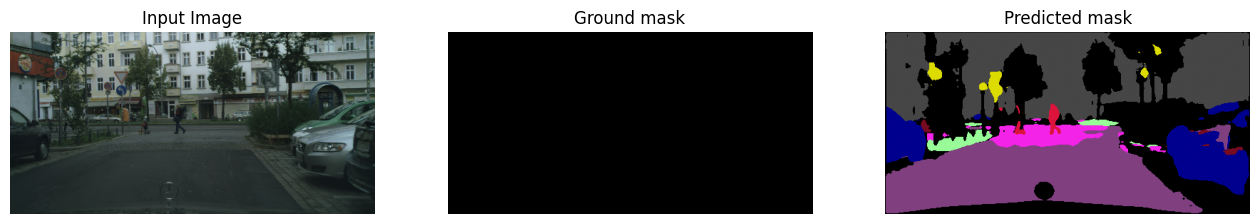

In [ ]:
# process single sample from test dataset
sample=0
# apply inverse normalisation to input image
invimg=inv_normalize(img_test[sample])
outputx=output_test.detach().cpu()[sample]
encoded_mask=encode_segmap(seg_test[sample].clone()) #(256, 512)
decoded_mask=decode_segmap(encoded_mask.clone())  #(256, 512)
decoded_ouput=decode_segmap(torch.argmax(outputx,0))

# create fig with three subplots
fig,ax=plt.subplots(ncols=3,figsize=(16,50),facecolor='white')  
ax[0].imshow(np.moveaxis(invimg.numpy(),0,2)) #(3,256, 512)
ax[1].imshow(decoded_mask) #(256, 512, 3)
ax[2].imshow(decoded_ouput) #(256, 512, 3)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Input Image')
ax[1].set_title('Ground mask')
ax[2].set_title('Predicted mask')
plt.savefig('result.png',bbox_inches='tight')

### Validation Set

In [ ]:
# create validation dataset from MyClass 
val_class = MyClass(DATA_DIR, split='val', mode='fine',
                                 target_type='semantic', transforms=transform)

# create validation data loader using dataset with batch size of 1
val_loader=DataLoader(val_class, batch_size=1, 
                      shuffle=False)

In [ ]:
# perform forward pass on val data using trained model
with torch.no_grad():
    for batch in val_loader:
        img_val,seg_val=batch
        output_val=model(img_val.cuda())
        break
# print shapes of input image
print(img_val.shape,seg_val.shape,output_val.shape)   

torch.Size([1, 3, 256, 512]) torch.Size([1, 256, 512]) torch.Size([1, 12, 256, 512])


#### Visualize Prediction

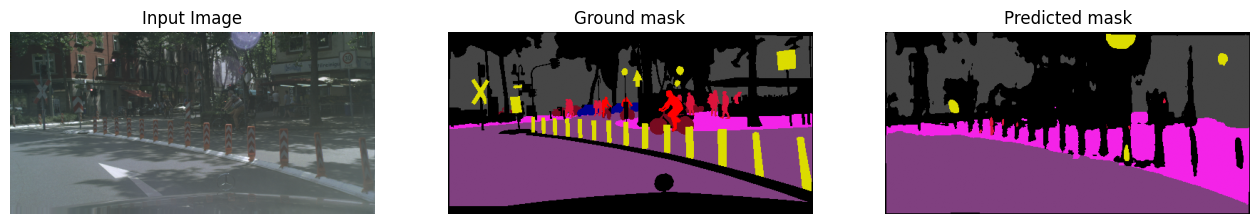

In [ ]:
# visualise input image, ground truth segmentation and predicted segmentation for
# a sample from the validation dataset.
sample=0
invimg=inv_normalize(img_val[sample])
outputx=output_val.detach().cpu()[sample]
encoded_mask=encode_segmap(seg_val[sample].clone()) #(256, 512)
decoded_mask=decode_segmap(encoded_mask.clone())  #(256, 512)
decoded_ouput=decode_segmap(torch.argmax(outputx,0))

# create fig with three subplots
fig,ax=plt.subplots(ncols=3,figsize=(16,50),facecolor='white')  
ax[0].imshow(np.moveaxis(invimg.numpy(),0,2)) #(3,256, 512)
ax[1].imshow(decoded_mask) #(256, 512, 3)
ax[2].imshow(decoded_ouput) #(256, 512, 3)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Input Image')
ax[1].set_title('Ground mask')
ax[2].set_title('Predicted mask')
plt.savefig('result.png',bbox_inches='tight')

## Metrics

### Accuracy

In [ ]:
#Model accuracry 1
correct_pixels = 0
total_pixels = 0
true_labels = []
pred_labels = []

model=model.cuda() 
model.eval() 
with torch.no_grad(): 
  for batch in test_loader: 
    img,seg=batch 
    output=model(img.cuda()) 

    predicted_masks = output.argmax(dim=1) 
    correct_pixels += (predicted_masks == seg.cuda()).sum().item() 
    total_pixels += seg.numel()

    predicted_maskss = predicted_masks.flatten().cpu().numpy()
    segmentss = seg.flatten().cpu().numpy()
    true_labels.extend(segmentss)
    pred_labels.extend(predicted_maskss)
    break
print(img.shape,seg.shape,output.shape) 
accuracy = (correct_pixels / total_pixels) * 100
print(f"Accuracy Rate: {accuracy}%")

torch.Size([1, 3, 256, 512]) torch.Size([1, 256, 512]) torch.Size([1, 12, 256, 512])
Accuracy Rate: 28.68499755859375%


In [ ]:
# model accuracy for test data (1 image)
# convert seg and output tensors to integer labels
seg_labels = seg[sample].argmax(dim=0)
pred_labels = outputx.argmax(dim=0)

# compare predicted and ground truth labels
correct_pixels = (pred_labels == seg_labels).sum().item()

# calculate total number of pixels
total_pixels = seg_labels.numel()

# calculate accuracy rate
accuracy = (correct_pixels / total_pixels) 
print('Accuracy rate =', accuracy)

Accuracy rate = 81.484375


In [ ]:
# list of averaging methods for Jaccard similarity score
averaging = [ 'micro', 'macro','weighted']

# iterate over each averaging method
for i in averaging:
  # compute Jaccard similarity score for the given averaging method
  get_jaccard(output_test, i)

micro  jaccard:  20.407507096466006 %
macro  jaccard:  3.7663777669270835 %
weighted  jaccard:  33.89739990234375 %


In [ ]:
# convert segmentation map to suitable format for evaluation
y_true = encode_segmap(seg)

# obtain predicted class labels by finding the class index with the highest probability
_,y_pred = torch.max(output_test, dim=1) 

# flatten the ground truth and predicted segmentation maps
y_true = y_true.view(-1)
y_pred = y_pred.view(-1)

# compute performance metrics for semantic segmentation
get_metrics(y_true.cpu().numpy(), y_pred.cpu().numpy())

[0.3389739990234375, 0.20407507096466007]

In [ ]:
# Initialize empty lists for storing metrics
train_loss_values = []
val_loss_values = []
train_iou_values = []
val_iou_values = []

# set no of epochs
num_epochs = 120

# Create data loaders for plotting
train_dataloader = model.train_dataloader()
val_dataloader = model.val_dataloader()

# Iterate over the epochs
for epoch in range(num_epochs):
    train_losses = []
    train_ious = []
    
    # Iterate over the training data and compute metrics
    for batch in train_dataloader:
        image, segment = batch
        image = image.to(device)
        segment = segment.to(device)
        with torch.no_grad():
            loss, iou = model.process(image, segment)
        train_losses.append(loss.item())
        train_ious.append(iou.item())
    
    # Compute the average loss and IoU for the epoch
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_train_iou = sum(train_ious) / len(train_ious)
    
    train_loss_values.append(avg_train_loss)
    train_iou_values.append(avg_train_iou)
    
    val_losses = []
    val_ious = []
    
    # Iterate over the validation data and compute metrics
    for batch in val_dataloader:
        image, segment = batch
        image = image.to(device)
        segment = segment.to(device)
        with torch.no_grad():
            loss, iou = model.process(image, segment)
        val_losses.append(loss.item())
        val_ious.append(iou.item())
    
    # Compute the average loss and IoU for the epoch
    avg_val_loss = sum(val_losses) / len(val_losses)
    avg_val_iou = sum(val_ious) / len(val_ious)
    
    val_loss_values.append(avg_val_loss)
    val_iou_values.append(avg_val_iou)

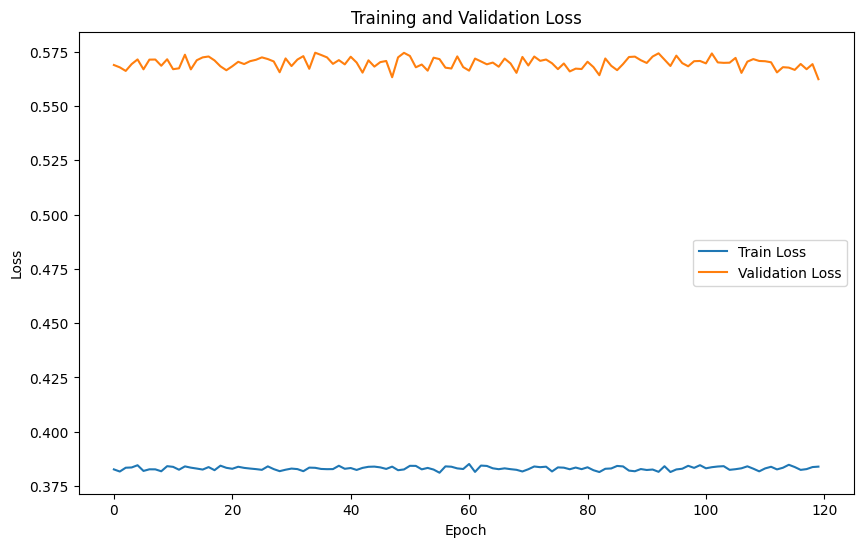

In [ ]:
# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# using torchsummary library to print summary of model, 
# including input size
model.eval()
summary(model, input_size=(3, 256, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 256]           9,408
       BatchNorm2d-2         [-1, 64, 128, 256]             128
              ReLU-3         [-1, 64, 128, 256]               0
         MaxPool2d-4          [-1, 64, 64, 128]               0
            Conv2d-5          [-1, 64, 64, 128]          36,864
       BatchNorm2d-6          [-1, 64, 64, 128]             128
              ReLU-7          [-1, 64, 64, 128]               0
            Conv2d-8          [-1, 64, 64, 128]          36,864
       BatchNorm2d-9          [-1, 64, 64, 128]             128
             ReLU-10          [-1, 64, 64, 128]               0
       BasicBlock-11          [-1, 64, 64, 128]               0
           Conv2d-12          [-1, 64, 64, 128]          36,864
      BatchNorm2d-13          [-1, 64, 64, 128]             128
             ReLU-14          [-1, 64, 